In [1]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

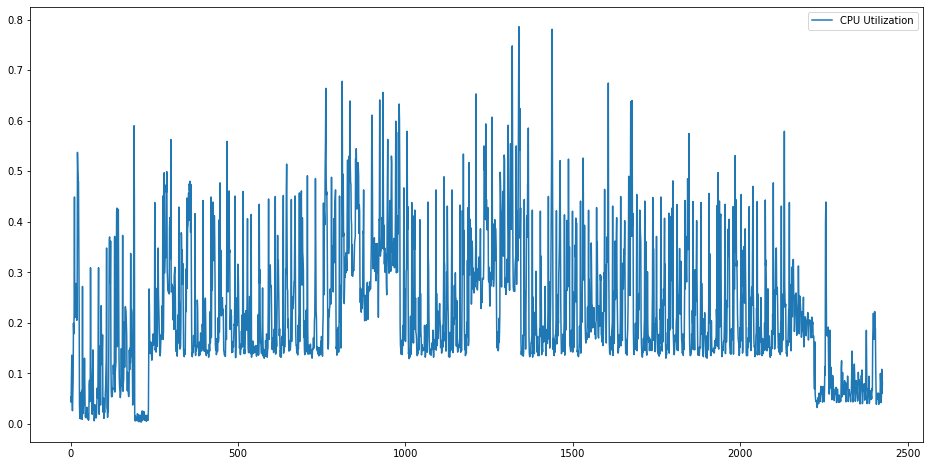

In [4]:
# let's load the dataset
df = pd.read_excel("./KSA_test.xlsx")
df.drop('Response Time', inplace=True, axis=1)
df.drop('Class Name', inplace=True, axis=1)
df.plot(figsize=(16,8))
plt.show()

In [6]:
# create train test split
train_length = round(len(df)*0.8)
test_length = len(df) - train_length
train = df.iloc[0:train_length]
test = df.iloc[train_length:]

In [7]:
# let's scale the values of the dataset
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [8]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_lags - 1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [10]:
TIME_STEPS = 50
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags=TIME_STEPS)
X_test, y_test = train_generator(test, n_lags=TIME_STEPS)

In [11]:
print(X_train.shape)

(1890, 50, 1)


# Let's build a dense network and test it out

In [12]:
# define the keras model
model_NN = tf.keras.Sequential()
model_NN.add(tf.keras.layers.Dense(32, input_dim=50, activation='relu'))
model_NN.add(tf.keras.layers.Dense(32, activation='relu'))
model_NN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [13]:
model_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_NN.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())

In [15]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [16]:
callbacks = [es, lr_red]
history = model_NN.fit(X_train, y_train, epochs=200, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/200
6/6 [==============================] - 0s 19ms/step - loss: 0.1857 - val_loss: 0.1367 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 4ms/step - loss: 0.1679 - val_loss: 0.1129 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 4ms/step - loss: 0.1610 - val_loss: 0.1035 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 4ms/step - loss: 0.1581 - val_loss: 0.0998 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 4ms/step - loss: 0.1559 - val_loss: 0.0983 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 0s 4ms/step - loss: 0.1536 - val_loss: 0.0982 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 0s 4ms/step - loss: 0.1512 - val_loss: 0.0987 - lr: 0.0010
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 0.1492 - val_loss: 0.0990 - lr: 0.0010
Epoch 9/200
6/6 [==============================] - 0s 4ms/step - loss: 0.1472 - val_loss: 0.0986 - lr: 0.0010
Epoch 10/

In [17]:
# sayyiv le modele when done
model_NN.save('./test_model_NN')

INFO:tensorflow:Assets written to: ./test_model_NN\assets


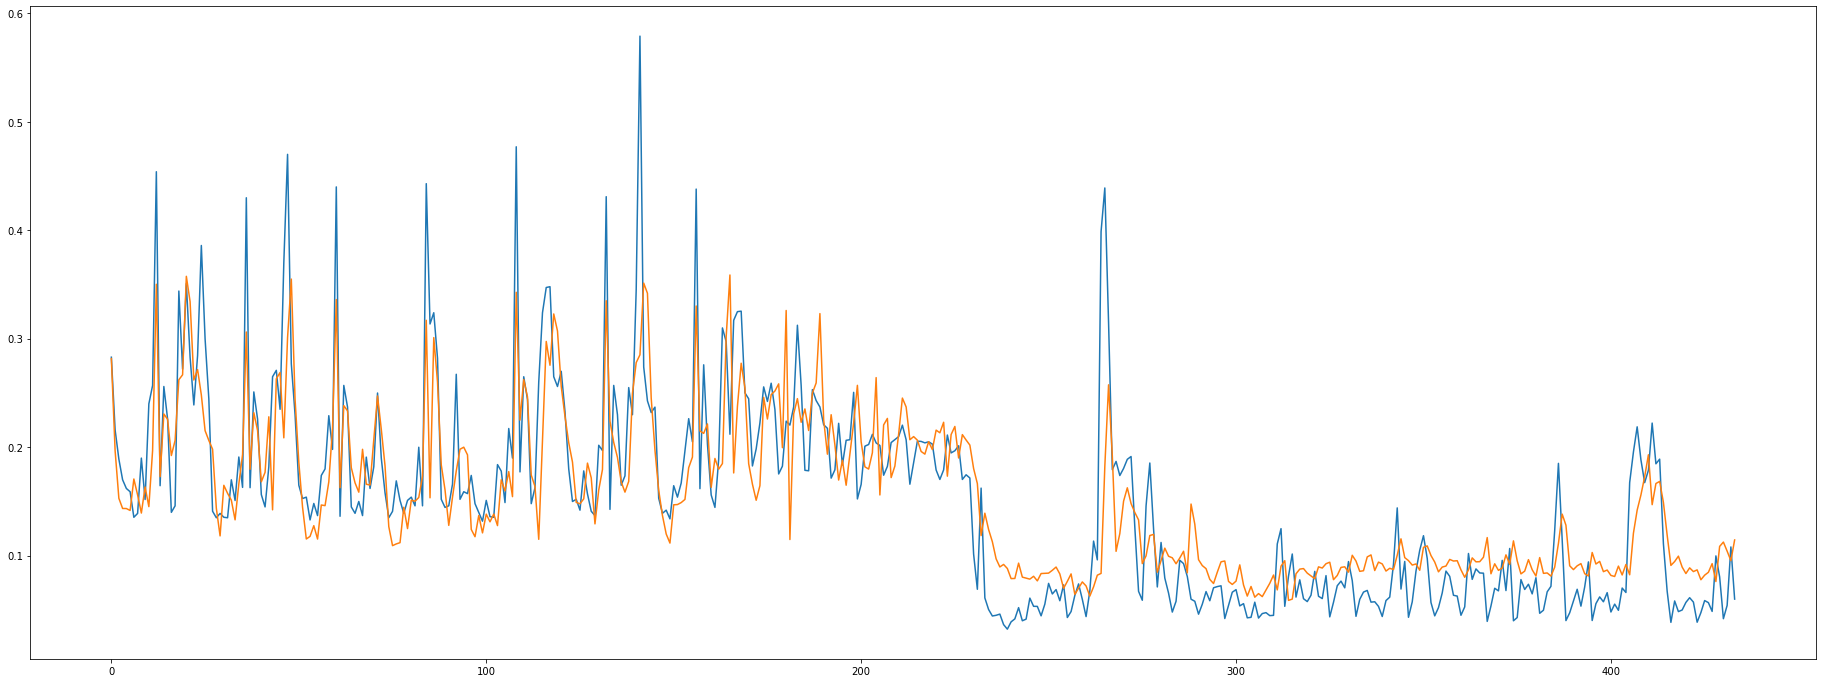

In [18]:
preds = model_NN.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_test, columns=['avg_cpu'])
PredY = pd.DataFrame(preds, columns=['avg_cpu'])

plot_avg = plt.figure(1)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [19]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 0.05 RMSE
Test Score: 0.191858 MAE
Test Score: 33.679345 MAPE


# Let's build an LSTM model

In [20]:
# let's build the lstm model
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(512, return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,152,385
Trainable params: 3,152,385
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_lstm.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())

In [22]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [23]:
callbacks = [es, lr_red]
history = model_lstm.fit(X_train, y_train, epochs=100, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/100
6/6 [==============================] - 11s 2s/step - loss: 0.1409 - val_loss: 0.1092 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 9s 2s/step - loss: 0.1285 - val_loss: 0.1240 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 9s 2s/step - loss: 0.1122 - val_loss: 0.0889 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 9s 2s/step - loss: 0.0924 - val_loss: 0.0880 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 9s 1s/step - loss: 0.0944 - val_loss: 0.0890 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 9s 1s/step - loss: 0.0900 - val_loss: 0.0852 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 9s 2s/step - loss: 0.0850 - val_loss: 0.0869 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 9s 1s/step - loss: 0.0853 - val_loss: 0.0842 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 9s 2s/step - loss: 0.0824 - val_loss: 0.0815 - lr: 0.0010
Epoch 10/100
6/6 [

In [24]:
# sayyiv le modele when done
model_lstm.save('./test_model_LSTM')

INFO:tensorflow:Assets written to: ./test_model_LSTM\assets


INFO:tensorflow:Assets written to: ./test_model_LSTM\assets


dict_keys(['loss', 'val_loss', 'lr'])


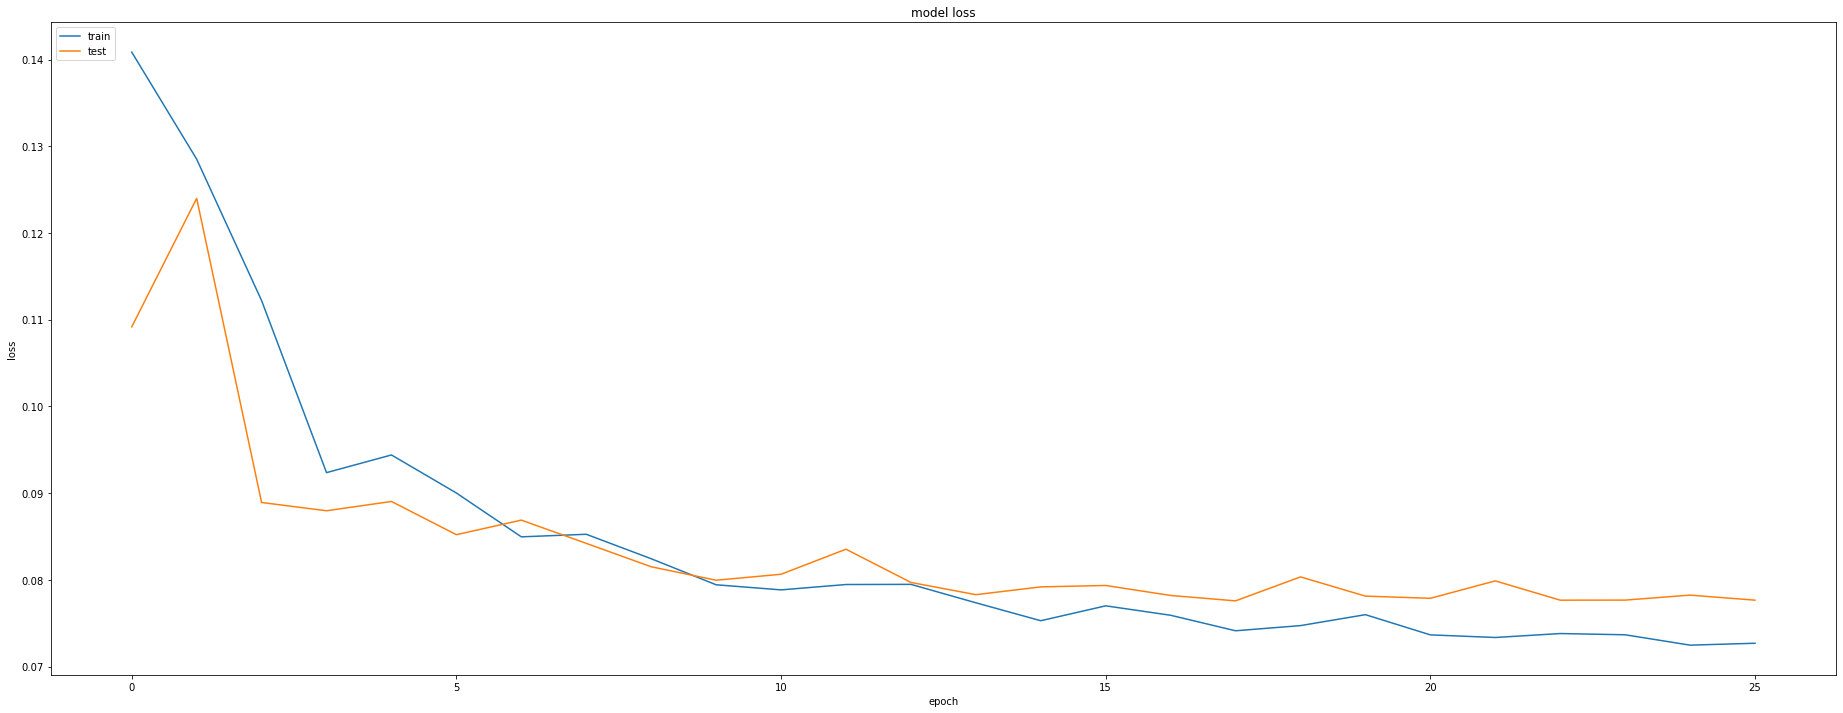

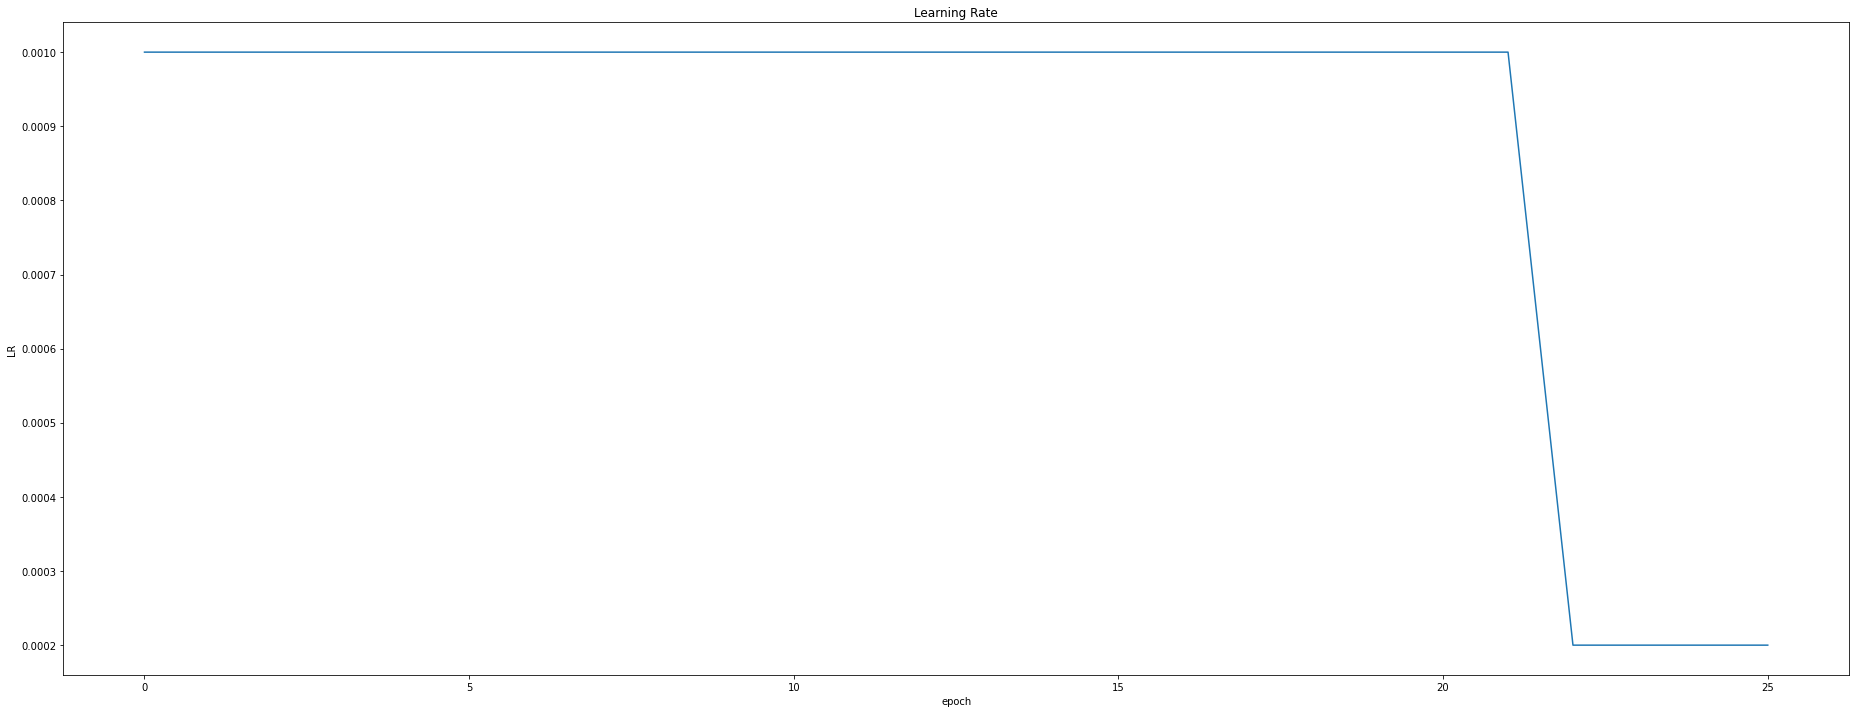

In [25]:
# try drawing the losses and the scores just to see where we are heading towards
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# why not also draw out the learning rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.show()

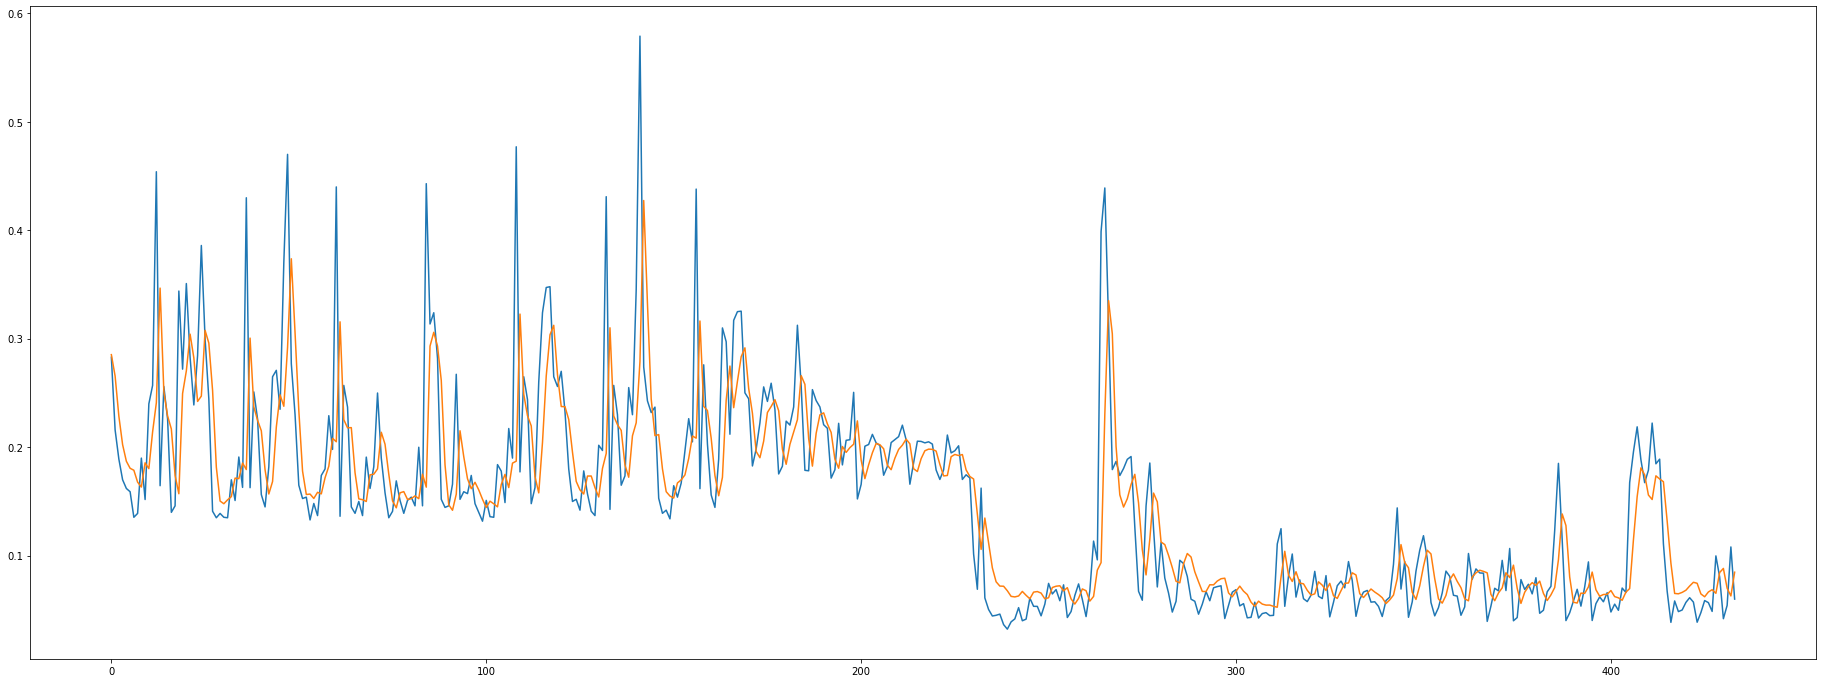

In [26]:
preds = model_lstm.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_test)
PredY = pd.DataFrame(preds)

plot_max = plt.figure(1)
plt.plot(TestY)
plt.plot(PredY)
plt.show()

In [27]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 0.06 RMSE
Test Score: 0.189315 MAE
Test Score: 26.734583 MAPE


# Let's try to implement a GRU

In [28]:
# let's build the lstm model
# return sequences?? -> 
model_GRU = tf.keras.models.Sequential()
model_GRU.add(tf.keras.layers.GRU(512,input_shape=(X_train.shape[1], 1),return_sequences=True))
model_GRU.add(tf.keras.layers.GRU(512, return_sequences=False))
model_GRU.add(tf.keras.layers.Dense(1))
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 512)           791040    
                                                                 
 gru_1 (GRU)                 (None, 512)               1575936   
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,367,489
Trainable params: 2,367,489
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_GRU.compile(loss="mean_absolute_error", optimizer= tf.keras.optimizers.Adam())
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [30]:
callbacks = [es, lr_red]
history = model_GRU.fit(X_train, y_train, epochs=100, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/100
6/6 [==============================] - 11s 1s/step - loss: 0.1128 - val_loss: 0.0829 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.0919 - val_loss: 0.1039 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 0.0909 - val_loss: 0.0806 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 8s 1s/step - loss: 0.0753 - val_loss: 0.0801 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 8s 1s/step - loss: 0.0756 - val_loss: 0.0833 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 8s 1s/step - loss: 0.0776 - val_loss: 0.0809 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 8s 1s/step - loss: 0.0748 - val_loss: 0.0813 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 0.0738
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6/6 [==============================] - 8s 1s/step - loss: 0.0738 - val_loss: 0.08

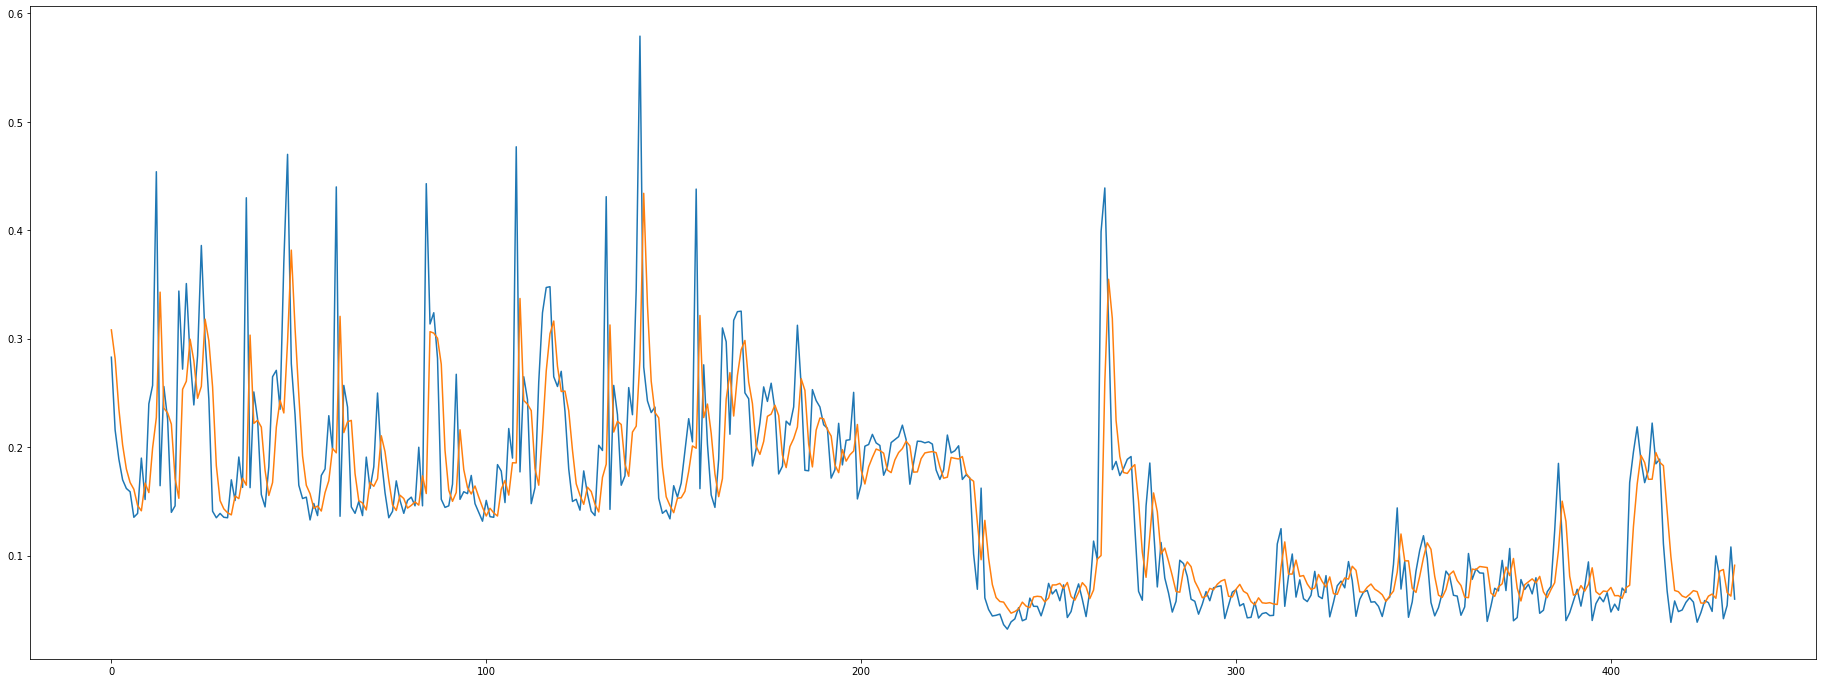

In [31]:
preds = model_GRU.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(y_test, columns=['avg_cpu'])
PredY = pd.DataFrame(preds, columns=['avg_cpu'])

plot_avg = plt.figure(1)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [32]:
# sayyiv le modele when done
model_GRU.save('./test_model_GPU')

INFO:tensorflow:Assets written to: ./test_model_GPU\assets


INFO:tensorflow:Assets written to: ./test_model_GPU\assets


In [33]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 0.06 RMSE
Test Score: 0.189941 MAE
Test Score: 26.237282 MAPE
